## Learning with Ensembles

In [ ]:
# Show how with 25% error rate in each classifier, it is higher when doing majority vote with ensemble
from scipy.special import comb
import math

# Function to compute the probability that an ensemble of classifiers 
# makes a wrong prediction given individual classifier error rates.
def ensemble_error(n_classifier, error):
    # Majority vote threshold: at least half (rounded up) must be wrong
    k_start = int(math.ceil(n_classifier / 2.))
    
    # Compute probability of k classifiers being wrong out of n_classifier
    probs = [
        comb(n_classifier, k) * error**k * (1 - error)**(n_classifier - k)
        for k in range(k_start, n_classifier + 1)
    ]
    
    # Total probability of the ensemble being wrong
    return sum(probs)

# Example: 11 classifiers, each with error rate = 0.25
print(ensemble_error(n_classifier=11, error=0.25))

0.03432750701904297


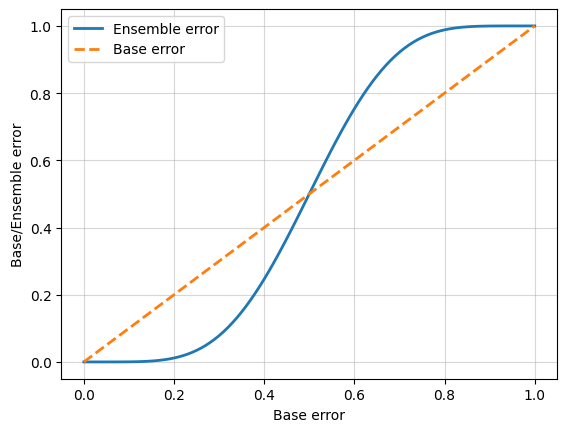

In [ ]:
# Visualize the ensemble error for different error rates
import numpy as np
import matplotlib.pyplot as plt

# Define a range of possible base error rates from 0 to 1
error_range = np.arange(0.0, 1.01, 0.01)

# Compute ensemble error for 11 classifiers across the base error range
ens_errors = [ensemble_error(n_classifier=11, error=error)
              for error in error_range]

# Plot ensemble error vs. base error
plt.plot(error_range, ens_errors,
         label='Ensemble error',
         linewidth=2)

# Plot baseline (ensemble error = base error, i.e., single classifier)
plt.plot(error_range, error_range,
         linestyle='--', label='Base error',
         linewidth=2)

# Labels, legend, and grid
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show() # as long as base classifiers perform better than random, ensemble will perform better